# Pet Adoption Speed Prediction using Transformer Models

This notebook implements word representation using transformer models (BERT) with PyTorch.

## Target: AdoptionSpeed (0-4)
- 0: Same day adoption
- 1: Adoption within 7 days
- 2: Adoption between 8-30 days
- 3: Adoption between 31-90 days
- 4: No adoption after 100 days

In [6]:

from google.colab import drive
drive.mount('/content/drive')

# Create a directory for the unzipped data if it doesn't exist
!mkdir -p data

# Unzip the specified file into the 'data' directory
!unzip -q "/content/drive/MyDrive/Work/APP Deep Learn/data/petfinder-adoption-prediction.zip" -d data

print("File unzipped successfully to the 'data' directory.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace data/BreedLabels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
File unzipped successfully to the 'data' directory.


In [7]:
# Import libraries
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 1. Load and Explore Data

In [8]:
# Load training data
# colab
df = pd.read_csv('data/train/train.csv')
# venv on VS code
# df = pd.read_csv('../data/train/train.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (14993, 24)

Columns: ['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed']

First few rows:


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


AdoptionSpeed distribution:
AdoptionSpeed
0     410
1    3090
2    4037
3    3259
4    4197
Name: count, dtype: int64


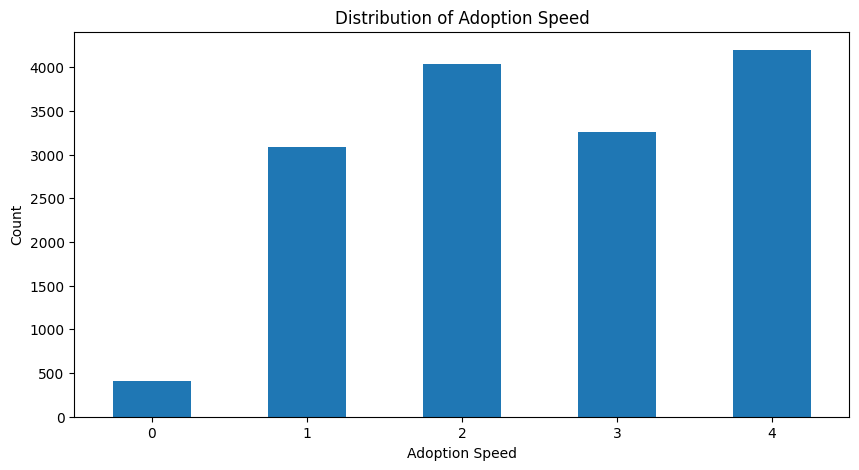

In [9]:
# Check target distribution
print("AdoptionSpeed distribution:")
print(df['AdoptionSpeed'].value_counts().sort_index())

# Visualize distribution
plt.figure(figsize=(10, 5))
df['AdoptionSpeed'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Adoption Speed')
plt.xlabel('Adoption Speed')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [10]:
# Check descriptions
print(f"Rows with descriptions: {df['Description'].notna().sum()}")
print(f"\nSample description:")
print(df[df['Description'].notna()]['Description'].iloc[0])

Rows with descriptions: 14980

Sample description:
Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.


In [11]:
# Explore metadata files
sample_pet_id = df['PetID'].iloc[0]
metadata_file = f'data/train_metadata/{sample_pet_id}-1.json'

if os.path.exists(metadata_file):
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    print(f"Metadata for {sample_pet_id}:")
    print(json.dumps(metadata, indent=2)[:500], "...")

Metadata for 86e1089a3:
{
  "labelAnnotations": [
    {
      "mid": "/m/01yrx",
      "description": "cat",
      "score": 0.9907862,
      "topicality": 0.9907862
    },
    {
      "mid": "/m/03dj64",
      "description": "black cat",
      "score": 0.9565297,
      "topicality": 0.9565297
    },
    {
      "mid": "/m/07k6w8",
      "description": "small to medium sized cats",
      "score": 0.9195353,
      "topicality": 0.9195353
    },
    {
      "mid": "/m/0307l",
      "description": "cat like mammal",
       ...


## 2. Create Dataset Class

In [12]:
class PetAdoptionDataset(Dataset):
    """Dataset for Pet Adoption with text metadata"""

    def __init__(self, dataframe, metadata_dir, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.metadata_dir = metadata_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pet_id = row['PetID']

        # Extract text from metadata
        text = self.extract_text_from_metadata(pet_id)

        # Add description if available
        if pd.notna(row.get('Description')):
            text = f"{row['Description']} {text}"

        # Tokenize text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(row['AdoptionSpeed'], dtype=torch.long)
        }

    def extract_text_from_metadata(self, pet_id):
        """Extract text descriptions from metadata JSON files"""
        texts = []

        # Check for metadata files with this PetID
        for i in range(1, 20):  # Max 20 images per pet
            metadata_file = os.path.join(self.metadata_dir, f"{pet_id}-{i}.json")

            if not os.path.exists(metadata_file):
                break

            try:
                with open(metadata_file, 'r') as f:
                    metadata = json.load(f)

                # Extract label annotations (descriptions)
                if 'labelAnnotations' in metadata:
                    descriptions = [label['description'] for label in metadata['labelAnnotations'][:5]]
                    texts.extend(descriptions)

            except Exception as e:
                continue

        return ' '.join(texts) if texts else 'no description'

## 3. Define Transformer Model

In [13]:
class TransformerPetClassifier(nn.Module):
    """Transformer-based classifier for pet adoption speed prediction"""

    def __init__(self, model_name='bert-base-uncased', num_classes=5, dropout=0.3):
        super(TransformerPetClassifier, self).__init__()

        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)

        # Get hidden size from transformer config
        hidden_size = self.transformer.config.hidden_size

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        # Get transformer outputs
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)

        # Classification
        logits = self.classifier(pooled_output)

        return logits

## 4. Training and Evaluation Functions

In [14]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    kappa = cohen_kappa_score(true_labels, predictions, weights='quadratic')

    return avg_loss, accuracy, kappa


def evaluate(model, dataloader, criterion, device):
    """Evaluate model"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    kappa = cohen_kappa_score(true_labels, predictions, weights='quadratic')

    return avg_loss, accuracy, kappa, predictions, true_labels

## 5. Configuration and Setup

In [15]:
# Configuration
MODEL_NAME = 'distilbert-base-uncased'  # Faster alternative: 'distilbert-base-uncased'
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 2e-5
NUM_CLASSES = 5

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 6. Prepare Data

In [16]:
# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['AdoptionSpeed']
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 11994
Validation size: 2999


In [17]:
# Initialize tokenizer
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading tokenizer: distilbert-base-uncased


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [18]:
# Create datasets
print("Creating datasets...")
train_dataset = PetAdoptionDataset(train_df, 'data/train_metadata', tokenizer, MAX_LENGTH)
val_dataset = PetAdoptionDataset(val_df, 'data/train_metadata', tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Creating datasets...
Train batches: 750
Validation batches: 188


In [19]:
# Test dataset - check a sample
sample = train_dataset[0]
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels'].item()}")

# Decode the tokens to see the text
decoded_text = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)
print(f"\nDecoded text (first 200 chars): {decoded_text[:200]}...")

Input IDs shape: torch.Size([128])
Attention mask shape: torch.Size([128])
Label: 2

Decoded text (first 200 chars): these 3 puppies was rescued from a mechanic shop in sentul, apparently we managed to save 4 out of the initially 6 puppies. also these 3 are really energetic and very playful, you will love their enth...


## 7. Initialize Model

In [20]:
# Initialize model
print(f"Initializing model: {MODEL_NAME}")
model = TransformerPetClassifier(
    model_name=MODEL_NAME,
    num_classes=NUM_CLASSES
).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler - reduces LR when validation kappa plateaus
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',          # Maximize kappa score
    factor=0.5,          # Reduce LR by 50%
    patience=3,          # Wait 3 epochs before reducing
    min_lr=1e-7          # Minimum learning rate
)

# Early stopping parameters
EARLY_STOPPING_PATIENCE = 7
early_stopping_counter = 0

print(f"✓ Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)")
print(f"✓ Early Stopping: patience={EARLY_STOPPING_PATIENCE}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Initializing model: distilbert-base-uncased


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✓ Scheduler: ReduceLROnPlateau (patience=3, factor=0.5)
✓ Early Stopping: patience=7

Total parameters: 66,593,285
Trainable parameters: 66,593,285


In [21]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## 8. Train Model

In [22]:
# Training loop with early stopping and LR scheduler
history = {
    'train_loss': [],
    'train_acc': [],
    'train_kappa': [],
    'val_loss': [],
    'val_acc': [],
    'val_kappa': [],
    'learning_rates': []
}

best_kappa = 0
early_stopping_counter = 0

for epoch in range(EPOCHS):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*50}")

    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate: {current_lr:.2e}")

    # Train
    train_loss, train_acc, train_kappa = train_epoch(
        model, train_loader, optimizer, criterion, device
    )

    # Validate
    val_loss, val_acc, val_kappa, val_preds, val_labels = evaluate(
        model, val_loader, criterion, device
    )

    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_kappa'].append(train_kappa)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_kappa'].append(val_kappa)
    history['learning_rates'].append(current_lr)

    print(f"\nTrain - Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Kappa: {train_kappa:.4f}")
    print(f"Val   - Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Kappa: {val_kappa:.4f}")

    # Learning rate scheduler step (monitors validation kappa)
    scheduler.step(val_kappa)

    # Check for improvement and handle early stopping
    if val_kappa > best_kappa:
        best_kappa = val_kappa
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        print(f"✓ Saved best model (Kappa: {best_kappa:.4f})")
    else:
        early_stopping_counter += 1
        print(f"⚠ No improvement for {early_stopping_counter}/{EARLY_STOPPING_PATIENCE} epoch(s)")

        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print(f"\n{'='*50}")
            print(f"🛑 Early stopping triggered!")
            print(f"{'='*50}")
            print(f"Training stopped at epoch {epoch + 1}/{EPOCHS}")
            print(f"Best validation kappa: {best_kappa:.4f}")
            break

print(f"\n{'='*50}")
print(f"Training completed!")
print(f"Best validation kappa: {best_kappa:.4f}")
print(f"{'='*50}")


Epoch 1/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.4839 | Acc: 0.2801 | Kappa: 0.0549
Val   - Loss: 1.4299 | Acc: 0.3418 | Kappa: 0.1437
✓ Saved best model (Kappa: 0.1437)

Epoch 2/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.4258 | Acc: 0.3491 | Kappa: 0.1843
Val   - Loss: 1.4160 | Acc: 0.3451 | Kappa: 0.1875
✓ Saved best model (Kappa: 0.1875)

Epoch 3/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.3662 | Acc: 0.3853 | Kappa: 0.2808
Val   - Loss: 1.4030 | Acc: 0.3781 | Kappa: 0.2300
✓ Saved best model (Kappa: 0.2300)

Epoch 4/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.2664 | Acc: 0.4356 | Kappa: 0.4089
Val   - Loss: 1.4658 | Acc: 0.3628 | Kappa: 0.2392
✓ Saved best model (Kappa: 0.2392)

Epoch 5/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.1370 | Acc: 0.4980 | Kappa: 0.5398
Val   - Loss: 1.5132 | Acc: 0.3708 | Kappa: 0.2478
✓ Saved best model (Kappa: 0.2478)

Epoch 6/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 1.0048 | Acc: 0.5605 | Kappa: 0.6440
Val   - Loss: 1.6743 | Acc: 0.3791 | Kappa: 0.2479
✓ Saved best model (Kappa: 0.2479)

Epoch 7/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.8971 | Acc: 0.6187 | Kappa: 0.7159
Val   - Loss: 1.8243 | Acc: 0.3535 | Kappa: 0.2323
⚠ No improvement for 1/7 epoch(s)

Epoch 8/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.8006 | Acc: 0.6614 | Kappa: 0.7750
Val   - Loss: 1.8444 | Acc: 0.3681 | Kappa: 0.2410
⚠ No improvement for 2/7 epoch(s)

Epoch 9/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.7034 | Acc: 0.7115 | Kappa: 0.8115
Val   - Loss: 2.0134 | Acc: 0.3731 | Kappa: 0.2509
✓ Saved best model (Kappa: 0.2509)

Epoch 10/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.6070 | Acc: 0.7595 | Kappa: 0.8467
Val   - Loss: 2.2729 | Acc: 0.3461 | Kappa: 0.2376
⚠ No improvement for 1/7 epoch(s)

Epoch 11/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.5065 | Acc: 0.8100 | Kappa: 0.8874
Val   - Loss: 2.3080 | Acc: 0.3621 | Kappa: 0.2357
⚠ No improvement for 2/7 epoch(s)

Epoch 12/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.4421 | Acc: 0.8384 | Kappa: 0.9043
Val   - Loss: 2.6063 | Acc: 0.3545 | Kappa: 0.2210
⚠ No improvement for 3/7 epoch(s)

Epoch 13/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.3639 | Acc: 0.8717 | Kappa: 0.9193
Val   - Loss: 2.6900 | Acc: 0.3645 | Kappa: 0.2354
⚠ No improvement for 4/7 epoch(s)

Epoch 14/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.3084 | Acc: 0.8944 | Kappa: 0.9333
Val   - Loss: 2.8167 | Acc: 0.3528 | Kappa: 0.2289
⚠ No improvement for 5/7 epoch(s)

Epoch 15/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.2640 | Acc: 0.9103 | Kappa: 0.9458
Val   - Loss: 2.9852 | Acc: 0.3731 | Kappa: 0.2334
⚠ No improvement for 6/7 epoch(s)

Epoch 16/50
Learning Rate: 2.00e-05


Training:   0%|          | 0/750 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]


Train - Loss: 0.2374 | Acc: 0.9185 | Kappa: 0.9492
Val   - Loss: 3.1089 | Acc: 0.3398 | Kappa: 0.1873
⚠ No improvement for 7/7 epoch(s)

🛑 Early stopping triggered!
Training stopped at epoch 16/50
Best validation kappa: 0.2509

Training completed!
Best validation kappa: 0.2509


## 9. Visualize Training History

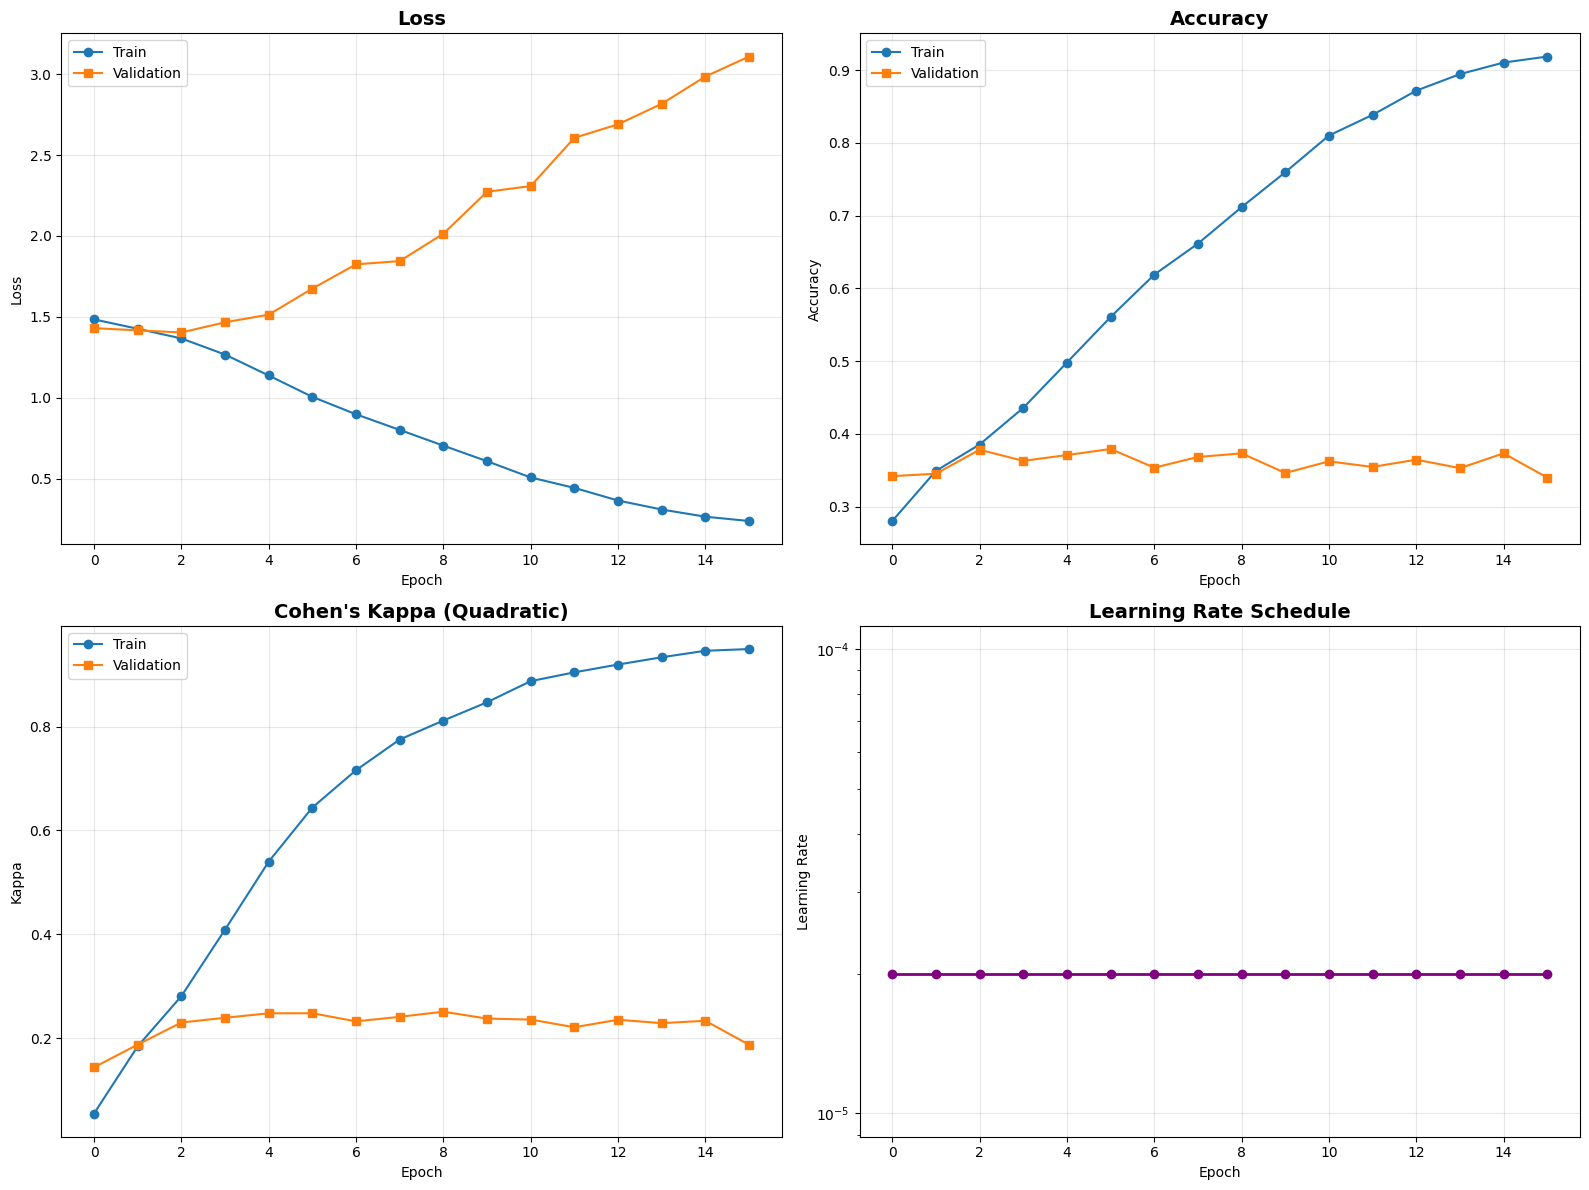


Training Summary:
Total epochs run: 16
Best validation kappa: 0.2509
Final learning rate: 2.00e-05


In [23]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
axes[0, 0].plot(history['val_loss'], label='Validation', marker='s')
axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train', marker='o')
axes[0, 1].plot(history['val_acc'], label='Validation', marker='s')
axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Kappa
axes[1, 0].plot(history['train_kappa'], label='Train', marker='o')
axes[1, 0].plot(history['val_kappa'], label='Validation', marker='s')
axes[1, 0].set_title('Cohen\'s Kappa (Quadratic)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Kappa')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['learning_rates'], marker='o', color='purple', linewidth=2)
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nTraining Summary:")
print(f"Total epochs run: {len(history['train_loss'])}")
print(f"Best validation kappa: {max(history['val_kappa']):.4f}")
print(f"Final learning rate: {history['learning_rates'][-1]:.2e}")

## 10. Final Evaluation

In [24]:
# Load best model
model.load_state_dict(torch.load('best_transformer_model.pth'))
val_loss, val_acc, val_kappa, val_preds, val_labels = evaluate(
    model, val_loader, criterion, device
)

print(f"Best Validation Results:")
print(f"Loss: {val_loss:.4f}")
print(f"Accuracy: {val_acc:.4f}")
print(f"Cohen's Kappa (Quadratic): {val_kappa:.4f}")

Evaluating:   0%|          | 0/188 [00:00<?, ?it/s]

Best Validation Results:
Loss: 2.0134
Accuracy: 0.3731
Cohen's Kappa (Quadratic): 0.2509


In [25]:
# Classification report
print("\nClassification Report:")
print(classification_report(
    val_labels,
    val_preds,
    target_names=[f'Speed {i}' for i in range(5)]
))


Classification Report:
              precision    recall  f1-score   support

     Speed 0       0.21      0.13      0.16        82
     Speed 1       0.31      0.31      0.31       618
     Speed 2       0.34      0.33      0.34       807
     Speed 3       0.33      0.27      0.30       652
     Speed 4       0.47      0.56      0.51       840

    accuracy                           0.37      2999
   macro avg       0.33      0.32      0.32      2999
weighted avg       0.36      0.37      0.37      2999



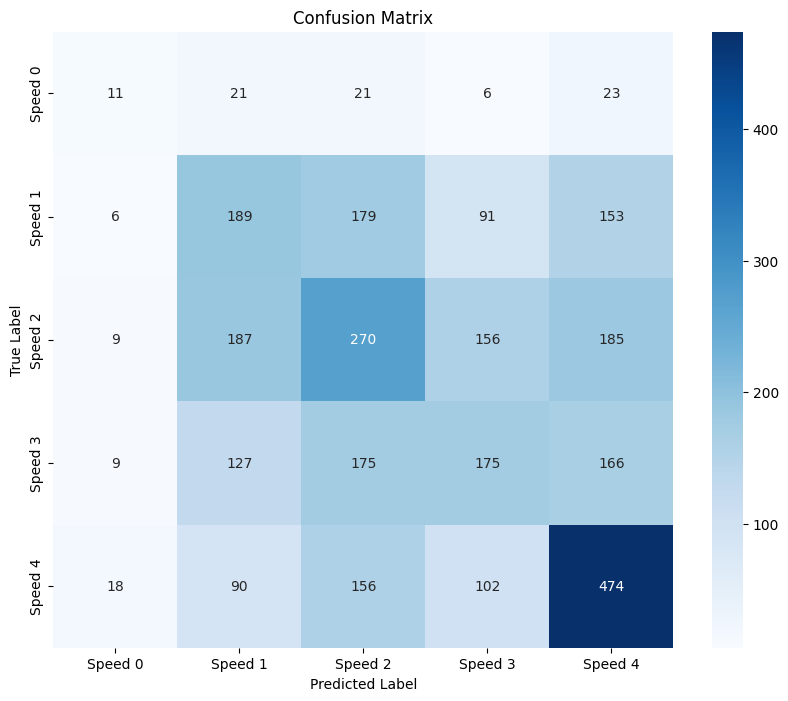

In [26]:
# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[f'Speed {i}' for i in range(5)],
    yticklabels=[f'Speed {i}' for i in range(5)]
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 11. Extract Text Embeddings (Optional)

In [27]:
# Function to extract embeddings from the transformer
def get_embeddings(model, dataloader, device):
    """Extract [CLS] token embeddings from transformer"""
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Extracting embeddings'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['labels']

            # Get transformer outputs
            outputs = model.transformer(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Extract [CLS] token embeddings
            cls_embeddings = outputs.last_hidden_state[:, 0, :]

            embeddings.append(cls_embeddings.cpu().numpy())
            labels.append(batch_labels.numpy())

    return np.vstack(embeddings), np.concatenate(labels)

# Extract embeddings
print("Extracting embeddings from validation set...")
val_embeddings, val_labels_array = get_embeddings(model, val_loader, device)
print(f"Embeddings shape: {val_embeddings.shape}")

Extracting embeddings from validation set...


Extracting embeddings:   0%|          | 0/188 [00:00<?, ?it/s]

Embeddings shape: (2999, 768)


Reducing dimensions with t-SNE...


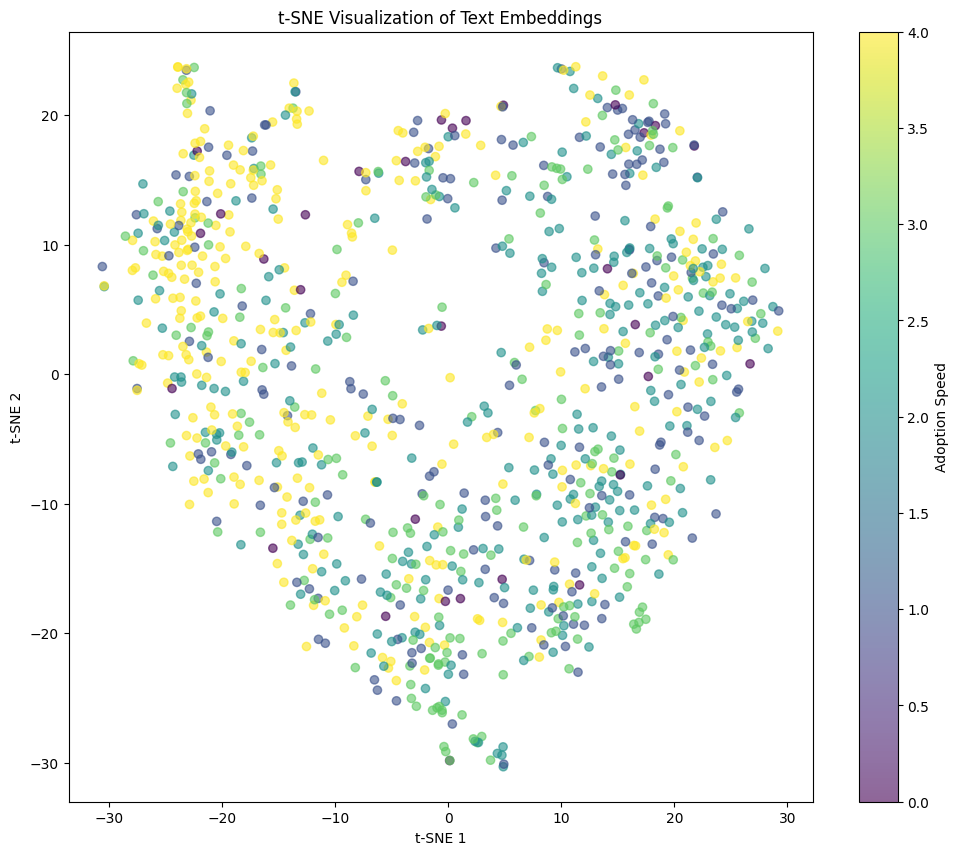

In [28]:
# Visualize embeddings with t-SNE or UMAP
from sklearn.manifold import TSNE

# Reduce dimensions for visualization
print("Reducing dimensions with t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(val_embeddings[:1000])  # Use subset for speed

# Plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=val_labels_array[:1000],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Adoption Speed')
plt.title('t-SNE Visualization of Text Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## 12. Save Model and Tokenizer

In [29]:
# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_name': MODEL_NAME,
    'num_classes': NUM_CLASSES,
    'max_length': MAX_LENGTH,
    'best_kappa': best_kappa
}, 'transformer_model_complete.pth')

# Save tokenizer
tokenizer.save_pretrained('tokenizer')

print("Model and tokenizer saved!")

Model and tokenizer saved!
